# This notebook (future script) is the basis of processing ERA5 files and calculating environmental variables for creating a ML TCGI. 

In [1]:
# Import libraries
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import time
import os
from functools import partial
from useful_functions import era_5_datestrings,generate_pathstrs

def _preprocess(x,level):
    return x.sel(level=level)

# Begin by sorting through which ERA5 files are desired for each variable, including the date intervals

In [2]:
data_interval = 7 # days
date_range_list = era_5_datestrings(data_interval)
variable_id = '138_vo' # for relative vorticity

all_path_strs = generate_pathstrs(date_range_list,variable_id,'sc')

# 1) Absolute Vorticity

In [3]:
# Open only pressure level 850 hPa

start = time.time()

level = 850 # hPa
partial_func = partial(_preprocess, level=level)

# Load weekly data
for begin_ind in np.arange(0,len(all_path_strs),data_interval):

    current_path_strs = all_path_strs[begin_ind:begin_ind+data_interval]
    datasets = xr.open_mfdataset(current_path_strs,preprocess=partial_func, parallel=True)['VO'].drop('level')
    # Create array Coriolis Parameter
    omega = 7.292 * 10 **-5 # 1/s
    f = 2*omega*np.sin(np.deg2rad(datasets.latitude))

    # Calculate Absolute Vorticity
    abs_vort = datasets + f

    # Calculate interval mean
    mean_abs_vort_850 = abs_vort.mean('time')
    mean_abs_vort_850 = mean_abs_vort_850.assign_coords({"beg":np.asarray(abs_vort['time'][0])})
    mean_abs_vort_850 = mean_abs_vort_850.assign_coords({"end":np.asarray(abs_vort['time'][-1])})

    # Save absolute vorticity
    path = "/glade/scratch/acheung/abs_vort"
    # Check whether the specified path exists or not
    isExist = os.path.exists(path)
    if not isExist:
    # Create a new directory because it does not exist
        os.makedirs(path) 


    variable_file_name_base = current_path_strs[0][57:90] + str(data_interval) + 'd_mean.'
    variable_file_name_start_time = current_path_strs[0][90:101]
    variable_file_name_end_time = current_path_strs[-1][101:]

    var_file_name_full = variable_file_name_base + variable_file_name_start_time + variable_file_name_end_time


    mean_abs_vort_850.to_dataset(name='Absolute Vorticity').to_netcdf(path+'/'+var_file_name_full)

# end time
end = time.time()

# total time taken
print(f"Runtime of the program is {end - start}")

KeyboardInterrupt: 

# 2) 850-200 hPa Vertical Wind Shear

In [3]:
data_interval = 7 # days
date_range_list = era_5_datestrings(data_interval)

# Generate path strings for u
variable_id_1= '131_u' # for relative vorticity
all_path_strs_1 = generate_pathstrs(date_range_list,variable_id_1,'uv')

# Generate path strings for v
variable_id_2= '132_v' # for relative vorticity
all_path_strs_2 = generate_pathstrs(date_range_list,variable_id_2,'uv')

start = time.time()

# Choose pressure levels (must be small to large)
level = [200,850] # hPa
partial_func = partial(_preprocess, level=level)

current_path_strs_1 = all_path_strs_1[0:7]
current_path_strs_2 = all_path_strs_2[0:7]

# Open u and v together
datasets = xr.open_mfdataset(current_path_strs_1 + current_path_strs_2,preprocess=partial_func, parallel=True)

wind_mags = np.sqrt(((datasets['U'])**2) + ((datasets['V'])**2))
mean_shear = (wind_mags.sel(level = 200) - wind_mags.sel(level = 850)).mean('time')
mean_shear = mean_shear.assign_coords({"beg":np.asarray(wind_mags['time'][0])})
mean_shear = mean_shear.assign_coords({"end":np.asarray(wind_mags['time'][-1])})
mean_shear = mean_shear.assign_coords({"lower_level":np.asarray(wind_mags['level'][-1])})
mean_shear = mean_shear.assign_coords({"upper_level":np.asarray(wind_mags['level'][0])})


# Save deep-layer shear
path = "/glade/scratch/acheung/dl_shear/"
# Check whether the specified path exists or not
isExist = os.path.exists(path)
if not isExist:
# Create a new directory because it does not exist
    os.makedirs(path) 


variable_file_name_base = current_path_strs_1[0][57:79] + 'DL_shear.'+current_path_strs_1[0][81:89]+str(data_interval) + 'd_mean.'
variable_file_name_start_time = current_path_strs_1[0][89:101]
variable_file_name_end_time = current_path_strs_1[-1][101:]

var_file_name_full = variable_file_name_base + variable_file_name_start_time + variable_file_name_end_time

mean_shear.to_dataset(name='Deep-Layer Shear').to_netcdf(path+'/'+var_file_name_full)

In [5]:
testing = xr.open_dataset(path+'/'+var_file_name_full)

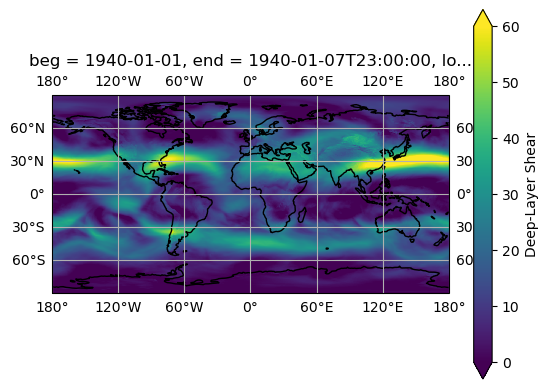

In [20]:
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
# ax.set_extent([-100, 0, 0, 50])
((testing['Deep-Layer Shear'])*-1).plot(vmin=0,vmax=60)